In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import sys
sys.path.append('../')
import h5py
import pandas as pd
import deepdish as dd
import os
import numpy as np
import pylab as plt
from glob import glob
from tqdm import tqdm
import seaborn as sns
from scipy.stats import ncx2
from pesummary.gw.conversions.spins import spin_angles
from GWFish.modules.detection import Network
from GWFish.modules.fishermatrix import compute_network_errors
import GWFish.modules as gwf_mods
import pathlib
from utils import get_detected_SNRs

## Get injection data SNRs

In [2]:
base_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
#inj_data_file = os.path.join(base_dir, 'SNR_output_files_XPHM', 'BBH', 
#                             'CE4020ET123_CoBA10_SNR_5_pop_set2_PLP_spin_prec_fref_5_z_MDlow_zp_1.54_zmax_10_lmrd_22_365_days_corrected_td_SNR_data.h5')
inj_data_file = os.path.join(base_dir, 'SNR_output_files_XPHM', 'BBH', 
                             'LHI_SNR_4_pop_PLP_spin_prec_fref_10_z_MDhigh_zp_2.53_zmax_10_lmrd_22_365_days_corrected_td_SNR_data.h5')

In [3]:
def decode_bytes_recursive(val):
    if isinstance(val, bytes):
        return val.decode('utf-8')
    elif isinstance(val, np.ndarray):
        if val.dtype.kind == 'S':  # Byte string array
            return np.vectorize(lambda x: x.decode('utf-8'))(val)
        elif val.dtype.kind in {'O'}:
            return np.vectorize(decode_bytes_recursive)(val)
        else:
            return val
    elif isinstance(val, list):
        return [decode_bytes_recursive(v) for v in val]
    elif isinstance(val, dict):
        return {k: decode_bytes_recursive(v) for k, v in val.items()}
    return val

def load_h5_group(group):
    data = {}
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Dataset):
            val = item[()]
            data[key] = decode_bytes_recursive(val)
        elif isinstance(item, h5py.Group):
            data[key] = load_h5_group(item)
    return data

In [4]:
# Main loader
inj_data = {}
with h5py.File(inj_data_file, 'r') as f:
    for key in f.keys():
        item = f[key]
        if isinstance(item, h5py.Dataset):
            val = item[()]
            inj_data[key] = decode_bytes_recursive(val)
        elif isinstance(item, h5py.Group):
            inj_data[key] = load_h5_group(item)

In [5]:
pd.DataFrame(inj_data['results'])

,PSD_H1,PSD_I1,PSD_L1,SNR_H1,SNR_I1,SNR_L1,SNR_mf_H1,SNR_mf_I1,SNR_mf_L1,SNR_mf_from_opt_H1,...,spin2x,spin2y,spin2z,srcmass1,srcmass2,srcmchirp,srcmtotal,theta_jn,time_interval,trigger_time
0,ASharp,ASharp,ASharp,4.731559,5.272083,4.794559,4.838913,5.502314,4.850968,5.517983,...,-0.491191,0.440124,0.459656,12.335285,11.962607,10.574779,24.297892,2.437242,419.545887,1.893024e+09
1,ASharp,ASharp,ASharp,0.446564,1.118472,0.344625,4.112025,4.174027,4.256305,1.557395,...,-0.007056,0.053092,0.037515,36.339138,12.682106,18.199637,49.021244,2.047701,258.511160,1.893025e+09
2,ASharp,ASharp,ASharp,5.256500,5.954638,5.121889,4.775228,5.881413,7.218168,6.701324,...,-0.025902,-0.027140,-0.010291,19.648225,8.015225,10.714259,27.663450,2.773617,1358.432362,1.893026e+09
3,ASharp,ASharp,ASharp,2.885351,1.002669,3.631510,4.381188,4.899725,6.079359,3.454516,...,-0.078996,-0.281103,-0.280170,35.272570,16.660915,20.815751,51.933485,1.944493,2745.493692,1.893029e+09
4,ASharp,ASharp,ASharp,0.854426,0.669835,0.862496,4.783119,4.703245,4.912413,1.812172,...,-0.020162,0.015121,0.000572,7.275936,2.511764,3.622301,9.787700,1.772502,1600.276633,1.893030e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49081,ASharp,ASharp,ASharp,1.850613,1.512040,2.503443,4.718560,4.719409,4.938775,2.441591,...,-0.560035,0.254727,-0.327346,7.440531,6.062218,5.840592,13.502749,1.403996,74.262463,1.924752e+09
49082,ASharp,ASharp,ASharp,3.857247,2.645842,4.076443,5.742781,5.337028,5.258969,3.584054,...,0.263771,0.028311,0.175887,10.684133,6.794064,7.379416,17.478197,2.387625,330.264870,1.924752e+09
49083,ASharp,ASharp,ASharp,3.531518,0.254008,4.765117,4.784921,4.760256,4.541496,4.391454,...,-0.278274,0.262500,-0.661914,13.830840,13.369727,11.837693,27.200567,0.519285,296.814710,1.924752e+09
49084,ASharp,ASharp,ASharp,1.245859,2.148441,2.000396,4.730140,5.239003,4.970667,1.714044,...,-0.104448,-0.270967,0.569766,9.132054,5.326931,6.028368,14.458985,1.699501,135.813700,1.924752e+09


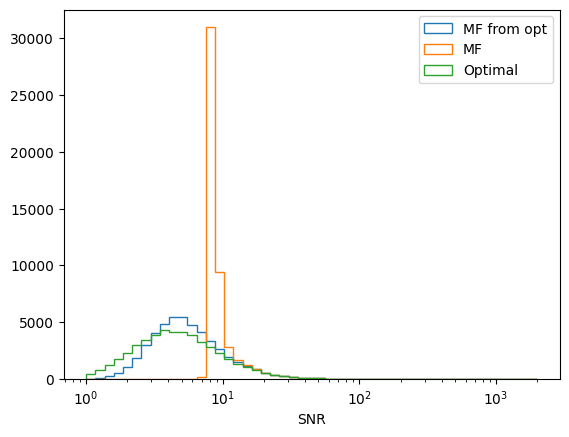

In [6]:
plt.hist(inj_data['results']['SNR_mf_from_opt_network'], bins=np.logspace(0,3.3,50), histtype=u'step', label='MF from opt');
plt.hist(inj_data['results']['SNR_mf_network'], bins=np.logspace(0,3.3,50), histtype=u'step', label='MF');
plt.hist(inj_data['results']['SNR_network'], bins=np.logspace(0,3.3,50), histtype=u'step', label='Optimal');
plt.xlabel('SNR')
plt.legend()
plt.xscale('log')

### Get detected

In [9]:
inj_data['detected'] = get_detected_SNRs(inj_data['results'], method='network', 
                                         snr_type='opt', network_threshold=10)

['SNR_H1', 'SNR_I1', 'SNR_L1', 'SNR_network']


### Detected percentage

In [10]:
n_total = len(inj_data['results']['redshift'])
#n_detected = len(inj_data['detected_mf_from_opt']['redshift'])
n_detected = len(inj_data['detected']['redshift'])

print('Total =', n_total)
print('detected =', n_detected, '=', round(n_detected*100/n_total, 1), '%')

Total = 49086
detected = 7076 = 14.4 %


### Choose n_events from detected as injection parameters

In [11]:
#n_events = 5200
n_events = len(inj_data['detected']['redshift'])
inj_data['selected_n_events'] = inj_data['detected'].sample(n_events, random_state=121).reset_index().rename(columns={'index': 'old_index'})
#inj_data['selected_n_events'].insert(5, 'SNR_ET', np.sqrt(inj_data['selected_n_events']['SNR_E1']**2 + inj_data['selected_n_events']['SNR_E2']**2 + inj_data['selected_n_events']['SNR_E3']**2))
#inj_data['selected_n_events'] = inj_data['detected_mf'].iloc[:n_events]

Text(0.5, 0, 'z')

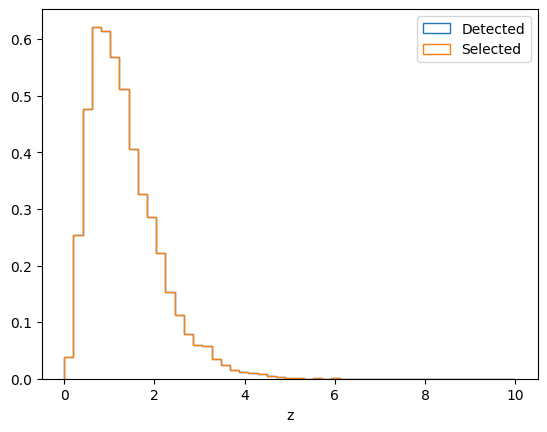

In [12]:
plt.hist(inj_data['detected']['redshift'], density=True, histtype=u'step', bins=np.linspace(0,10,50), 
         label='Detected')
plt.hist(inj_data['selected_n_events']['redshift'], density=True, histtype=u'step', 
         bins=np.linspace(0,10,50), label='Selected');
plt.legend()
plt.xlabel('z')

In [13]:
len(inj_data['selected_n_events']['redshift'])

7076

## FM analysis with GWFish

In [14]:
inj_data['selected_n_events'].keys()

Index(['old_index', 'PSD_H1', 'PSD_I1', 'PSD_L1', 'SNR_H1', 'SNR_I1', 'SNR_L1',
       'SNR_mf_H1', 'SNR_mf_I1', 'SNR_mf_L1', 'SNR_mf_from_opt_H1',
       'SNR_mf_from_opt_I1', 'SNR_mf_from_opt_L1', 'SNR_mf_from_opt_network',
       'SNR_mf_network', 'SNR_network', 'approximant', 'chi_1_in_plane',
       'chi_2_in_plane', 'chi_eff', 'chi_p', 'coa_phase', 'cos_spin1_polar',
       'cos_spin2_polar', 'dec', 'delta_f', 'distance', 'eta', 'f_final',
       'f_lower', 'f_ref', 'inclination', 'mass1', 'mass2', 'mchirp', 'mtotal',
       'phi_12', 'phi_jl', 'polarization', 'q', 'ra', 'redshift', 'spin1_a',
       'spin1_azimuthal', 'spin1_polar', 'spin1x', 'spin1y', 'spin1z',
       'spin2_a', 'spin2_azimuthal', 'spin2_polar', 'spin2x', 'spin2y',
       'spin2z', 'srcmass1', 'srcmass2', 'srcmchirp', 'srcmtotal', 'theta_jn',
       'time_interval', 'trigger_time'],
      dtype='object')

In [15]:
pycbc_to_pesummary_map = {
    'mchirp': 'chirp_mass',
    'q': 'mass_ratio',
    'distance': 'luminosity_distance',
    'theta_jn': 'theta_jn',
    'ra': 'ra',
    'dec': 'dec',
    'polarization': 'psi',
    'trigger_time': 'geocent_time',
    'coa_phase': 'phase',
    'spin1_a': 'a_1',
    'spin2_a': 'a_2',
    'spin1_polar': 'tilt_1',
    'spin2_polar':'tilt_2',
    'phi_12': 'phi_12',
    'phi_jl': 'phi_jl',
    'mass1': 'mass_1',
    'mass2': 'mass_2'
}
#gwfish_det_dict = {'L1':'L', 'H1':'H', 'I1':'IN'}

In [16]:
gwfish_input_data = {pycbc_to_pesummary_map[key]:inj_data['selected_n_events'][key] for key in pycbc_to_pesummary_map.keys() if key != 'q'}
gwfish_input_data = pd.DataFrame(gwfish_input_data)
gwfish_input_data['mass_ratio'] = 1/inj_data['selected_n_events']['q']

In [17]:
gwfish_input_data

,chirp_mass,luminosity_distance,theta_jn,ra,dec,psi,geocent_time,phase,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,mass_1,mass_2,mass_ratio
0,7.478498,999.302793,2.368253,4.607805,0.899867,1.902420,1.911476e+09,3.924111,0.404507,0.439751,1.673627,0.985664,6.215021,2.679380,12.015590,6.270777,0.521887
1,62.057239,10586.605518,2.702627,2.117551,0.811807,1.243261,1.897285e+09,0.526213,0.341339,0.913370,2.065315,1.514926,5.963218,1.297151,81.300358,62.713840,0.771385
2,100.757323,32401.401807,2.994569,5.860739,0.446644,0.294868,1.897702e+09,0.841669,0.883675,0.967095,0.671259,2.478545,0.396689,1.671264,129.795651,103.470945,0.797183
3,8.075699,2892.304303,1.242280,1.633246,-0.112182,2.062885,1.899515e+09,3.798648,0.634571,0.629860,0.516030,1.552695,3.251882,3.350803,14.267100,6.235972,0.437088
4,11.192143,4584.405125,1.003336,4.765095,0.046398,0.361434,1.911880e+09,5.059527,0.139738,0.263529,1.980184,2.166417,1.815887,4.459486,17.718028,9.508304,0.536646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7071,40.119176,13569.514518,0.564240,5.630626,-0.513695,0.291529,1.902407e+09,1.894709,0.054398,0.010223,2.648656,1.733787,4.701045,4.240131,76.821847,28.943403,0.376760
7072,69.084497,11955.992780,2.561084,2.601409,-0.316567,2.215334,1.908883e+09,5.366061,0.722093,0.000101,1.520801,0.267708,4.683512,2.116702,83.332159,75.607689,0.907305
7073,43.671957,17355.157652,0.164410,4.156765,0.538893,1.844920,1.900319e+09,5.067365,0.218093,0.111324,0.949562,2.088216,2.978659,5.302707,53.014305,47.499182,0.895969
7074,85.090722,16555.749583,0.828713,1.311328,0.097334,1.103583,1.913277e+09,2.741468,0.712230,0.968289,0.792839,1.626215,3.490813,3.831560,122.043168,79.019446,0.647471


In [18]:
file_str = inj_data_file.split('/')[-1]
for repl_tup in [('_pop_PLP', '_PLP'), 
                 ('_SNR', ''), 
                 ('_spin_prec', ''), 
                 ('_fref_5', ''), 
                 ('_365_days_corrected_td_data.h5', '')]:
    file_str = file_str.replace(repl_tup[0], repl_tup[1])
file_str

'LHI_4_PLP_fref_10_z_MDhigh_zp_2.53_zmax_10_lmrd_22'

In [19]:
if 'set' in file_str:
    set_num = file_str.split('set')[-1].split('_')[0]
    file_str = file_str.replace('pop_', '').replace('set'+set_num+'_', '').replace('PLP_', 'PLP_set'+set_num+'_')
file_str

'LHI_4_PLP_fref_10_z_MDhigh_zp_2.53_zmax_10_lmrd_22'

In [20]:
if 'CE4020ET123' in file_str:
    detectors = ['CE1', 'CE2', 'ET']
elif 'LHI' in file_str:
    detectors = ['A_sharp_L', 'A_sharp_H', 'A_sharp_IN']
matrix_file_names = f'{file_str}_no_spins_{n_events}_events_pop_from_XPHM_det10_opt_netw'
#matrix_file_names = f'LHI_5_PLP_z_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_{n_events}_events_pop_from_XPHM_det10_opt'
print(detectors)
print(matrix_file_names)

['A_sharp_L', 'A_sharp_H', 'A_sharp_IN']
LHI_4_PLP_fref_10_z_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_7076_events_pop_from_XPHM_det10_opt_netw


### Without parallelization

In [43]:
results = {'detected_idxs':[], 
           'netw_snrs':[], 
           'errors':[],
           'sky_locs':[]}
fisher_params = ['chirp_mass', 'mass_ratio', 'luminosity_distance', 'theta_jn', 'phase', 'geocent_time', 'ra', 'dec', 'psi']
network = gwf_mods.detection.Network(detector_ids = detectors, detection_SNR = (0., 5.), config=pathlib.Path('detectors.yaml'))
#for event_num in tqdm(range(len(inj_data['selected_n_events']))):
results['detected_idxs'], results['netw_snrs'], results['errors'], results['sky_locs'] = compute_network_errors(
    network=network, 
    parameter_values=gwfish_input_data,
    fisher_parameters=fisher_params, 
    f_ref=inj_data['selected_n_events']['f_ref'][0], 
    waveform_model='IMRPhenomXPHM',
    save_matrices=True,
    save_matrices_path=pathlib.Path(os.path.join(base_dir, 
                                                 'GWFish_analysis', 
                                                 'BBH',
                                                 'Fisher_matrices')),
    matrix_naming_postfix=matrix_file_names
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5949/5949 [2:51:24<00:00,  1.73s/it]


### With parallelization

In [21]:
nprocs = 8
from gwfish_functions import parallel_compute_network_errors, combine_and_archive_fisher_matrices

In [ ]:
fisher_params = ['chirp_mass', 'mass_ratio', 'luminosity_distance', 'theta_jn', 'phase', 'geocent_time', 'ra', 'dec', 'psi']
network = gwf_mods.detection.Network(detector_ids = detectors, detection_SNR = (0., 1.), config=pathlib.Path('detectors.yaml'))
results = {}
results['detected_idxs'], results['netw_snrs'], results['errors'], results['sky_locs'] = (
    parallel_compute_network_errors(
        network=network,
        gwfish_input_data=gwfish_input_data,
        fisher_params=fisher_params,
        f_ref=inj_data['selected_n_events']['f_ref'][0],
        base_dir=base_dir,
        matrix_file_names=matrix_file_names,
        nproc=nprocs
    )
)

 28%|██▊       | 244/885 [17:58<47:10,  4.42s/it]  

In [21]:
combine_and_archive_fisher_matrices(
    base_dir=os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Fisher_matrices'),
    matrix_file_prefix=f'fisher_matrices_{matrix_file_names}',
    n_chunks=nprocs,
    output_file=os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Fisher_matrices', f'fisher_matrices_{matrix_file_names}.npy')
)

combine_and_archive_fisher_matrices(
    base_dir=os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Fisher_matrices'),
    matrix_file_prefix=f'inv_fisher_matrices_{matrix_file_names}',
    n_chunks=nprocs,
    output_file=os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Fisher_matrices', f'inv_fisher_matrices_{matrix_file_names}.npy')
)

Combined Fisher matrices saved to /home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Fisher_matrices/fisher_matrices_LHI_4_PLP_fref_10_z_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_6720_events_pop_from_XPHM_det10_opt.npy
Moved 8 chunked Fisher matrix files to /home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Fisher_matrices/chunks
Combined Fisher matrices saved to /home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Fisher_matrices/inv_fisher_matrices_LHI_4_PLP_fref_10_z_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_6720_events_pop_from_XPHM_det10_opt.npy
Moved 8 chunked Fisher matrix files to /home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Fisher_matrices/chunks


In [22]:
results['errors'] = pd.DataFrame(results['errors'], columns=fisher_params)
results['errors']

,chirp_mass,mass_ratio,luminosity_distance,theta_jn,phase,geocent_time,ra,dec,psi
0,0.117510,0.362580,8794.672982,0.595313,194.979010,0.002127,0.044391,0.102049,97.475992
1,0.007293,0.015493,2057.054228,0.484075,28.328906,0.000367,0.045152,0.022374,14.164823
2,0.001792,0.014407,775.318293,0.158529,0.911229,0.000223,0.028319,0.028137,0.477192
3,0.000857,0.016785,124.233012,0.043615,0.212673,0.000674,0.055779,0.063417,0.038544
4,0.091657,0.417292,7989.507119,0.628742,18.965775,0.002767,0.030188,0.071358,9.550566
...,...,...,...,...,...,...,...,...,...
6715,0.001152,0.017476,1933.712686,0.485069,27.385772,0.000397,0.050704,0.029729,13.666421
6716,0.000482,0.003681,497.223415,0.206906,6.940188,0.000232,0.008360,0.019244,3.466835
6717,0.000913,0.038613,1030.978297,0.294409,4.332553,0.000154,0.025309,0.008897,2.168638
6718,0.007486,0.017103,1377.280131,0.305794,29.846743,0.000643,0.032190,0.052489,14.907260


### Add original parameters to the results dict

In [23]:
results['all_inj_params_original'] = inj_data['selected_n_events']
results['all_inj_params_original'].loc[:,'log_distance'] = np.log(results['all_inj_params_original']['distance'])
results['all_inj_params_original'].loc[:, 'inv_q'] = 1/results['all_inj_params_original']['q']

In [24]:
results['deriv_variables_in_order'] = np.array(results['errors'].keys(), dtype=h5py.string_dtype(encoding='utf-8'))
results['deriv_variables_in_order']

array(['chirp_mass', 'mass_ratio', 'luminosity_distance', 'theta_jn',
       'phase', 'geocent_time', 'ra', 'dec', 'psi'], dtype=object)

In [25]:
pesummary_to_pycbc_map = {
    'chirp_mass':'mchirp',
    'mass_ratio':'inv_q',
    'luminosity_distance':'distance',
    'theta_jn':'theta_jn',
    'phase':'coa_phase',
    'geocent_time':'trigger_time',
    'ra':'ra',
    'dec':'dec',
    'psi':'polarization'
}

In [26]:
results['inj_params'] = pd.DataFrame({key:results['all_inj_params_original'][pesummary_to_pycbc_map[key]] for key in results['deriv_variables_in_order']})
results['inj_params']

,chirp_mass,mass_ratio,luminosity_distance,theta_jn,phase,geocent_time,ra,dec,psi
0,158.378590,0.858548,47193.365922,2.801795,0.034050,1.893063e+09,4.870616,-0.690375,1.273878
1,22.371852,0.535404,11439.170168,0.304213,5.371443,1.896530e+09,1.166833,0.219704,2.499049
2,16.974061,0.597602,5058.621301,2.409198,0.368453,1.893988e+09,2.987350,-1.247216,2.644232
3,8.230063,0.850624,1620.192183,1.449506,4.399117,1.897014e+09,2.016220,-0.025941,0.057550
4,122.555495,0.948967,23373.655462,0.458409,3.439097,1.899610e+09,4.277627,0.536210,1.622580
...,...,...,...,...,...,...,...,...,...
6715,39.640779,0.988708,17890.037581,0.329830,5.971307,1.902950e+09,1.059384,0.574800,0.158877
6716,10.068266,0.365363,4772.229212,2.848149,1.775975,1.909740e+09,4.527375,-0.795138,2.345165
6717,13.415150,0.779077,6954.198314,0.516271,3.231516,1.900745e+09,3.798564,-0.261044,0.467797
6718,28.202476,0.528519,12186.461178,2.794710,2.997427,1.914379e+09,5.299141,0.186352,0.569031


In [27]:
load_inv_matrices = np.load(os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Fisher_matrices', 
                                         f'inv_fisher_matrices_{matrix_file_names}.npy'))

In [28]:
len(load_inv_matrices)

6720

In [29]:
results['cov'] = load_inv_matrices

## Sanity checks

### Check if cov matrices are positive-definite

In [30]:
failed = []
for event in range(len(results['all_inj_params_original'])):
    cov = load_inv_matrices[event]  # the covariance matrix
    try:
        np.linalg.cholesky(cov)
    except np.linalg.LinAlgError:
        failed.append(event)

In [31]:
failed

[16, 1194, 2235, 5618]

In [32]:
failed_dict = {}
if len(failed) !=0:
    failed_dict['inj_params'] = results['inj_params'].loc[failed]
    failed_dict['all_inj_params_original'] = results['all_inj_params_original'].loc[failed]

In [33]:
failed_dict['inj_params']

,chirp_mass,mass_ratio,luminosity_distance,theta_jn,phase,geocent_time,ra,dec,psi
16,125.014721,0.829989,16055.857406,0.128059,5.414301,1.902780e+09,2.863911,-0.682652,1.530545
1194,7.814051,0.526383,3154.910576,3.097876,6.172099,1.920803e+09,2.875950,-0.936808,1.686347
2235,35.419902,0.933816,8818.153401,3.089125,4.737157,1.916970e+09,4.777463,-0.493975,0.886096
5618,109.726089,0.726795,32730.326657,3.091170,3.293108,1.921679e+09,4.133802,0.635458,1.935054


In [34]:
print(len(results['inj_params']))

6720


In [35]:
results.keys()

dict_keys(['detected_idxs', 'netw_snrs', 'errors', 'sky_locs', 'all_inj_params_original', 'deriv_variables_in_order', 'inj_params', 'cov'])

In [36]:
[(key, type(results[key])) for key in results.keys()]

[('detected_idxs', numpy.ndarray),
 ('netw_snrs', numpy.ndarray),
 ('errors', pandas.core.frame.DataFrame),
 ('sky_locs', numpy.ndarray),
 ('all_inj_params_original', pandas.core.frame.DataFrame),
 ('deriv_variables_in_order', numpy.ndarray),
 ('inj_params', pandas.core.frame.DataFrame),
 ('cov', numpy.ndarray)]

In [37]:
results_updated = {}
for key in results.keys():
    if key == 'detected_idxs':
        continue
    if key == 'deriv_variables_in_order':
        results_updated[key] = results[key]
    else:
        if len(failed) == 0:
            print("No failed events")
            results_updated[key] = results[key]
        else:
            if isinstance(results[key], pd.DataFrame):
                results_updated[key] = results[key].drop(index=failed)
            elif isinstance(results[key], np.ndarray):
                results_updated[key] = np.array([results[key][i] for i in range(len(results[key])) if i not in failed])

In [38]:
print(len(results_updated['inj_params']))

6716


### Check for positive-definite again

In [39]:
failed2 = []
for event in range(len(results_updated['all_inj_params_original'])):
    cov = results_updated['cov'][event]  # the covariance matrix
    try:
        np.linalg.cholesky(cov)
    except np.linalg.LinAlgError:
        failed2.append(event)

In [40]:
failed2

[]

In [41]:
results.keys()

dict_keys(['detected_idxs', 'netw_snrs', 'errors', 'sky_locs', 'all_inj_params_original', 'deriv_variables_in_order', 'inj_params', 'cov'])

### DL errors are reasonable

Text(0.5, 0, '$\\Delta D_L / D_L$')

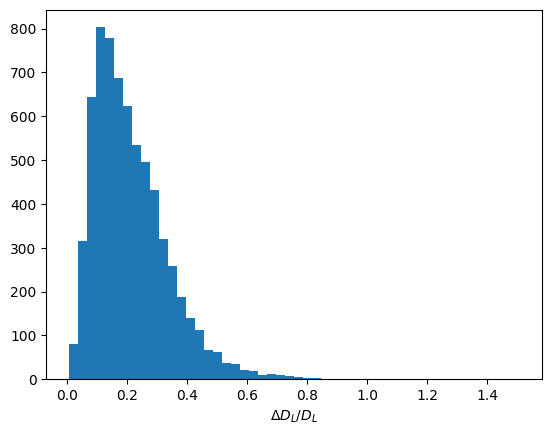

In [42]:
plt.hist(results_updated['errors']['luminosity_distance']/results_updated['all_inj_params_original']['distance'], bins=50);
plt.xlabel('$\Delta D_L / D_L$')

Text(0.5, 0, 'Network SNR')

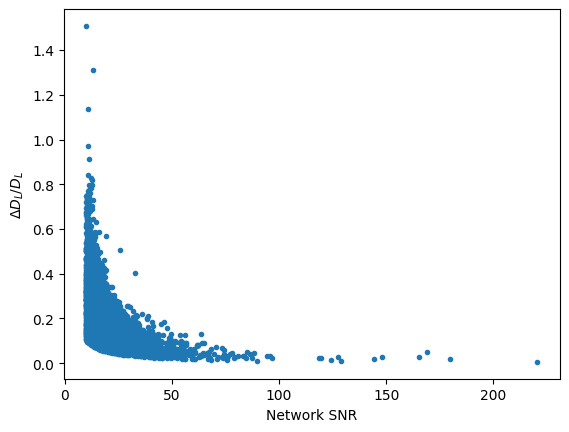

In [43]:
plt.plot(results_updated['netw_snrs'], 
         results_updated['errors']['luminosity_distance']/results_updated['all_inj_params_original']['distance'], '.')
plt.ylabel('$\Delta D_L / D_L$')
plt.xlabel('Network SNR')

### Check the recomibing has not messed up matrix orders

In [44]:
dl_idx = list(results_updated['errors'].keys()).index('luminosity_distance')
dl_idx

2

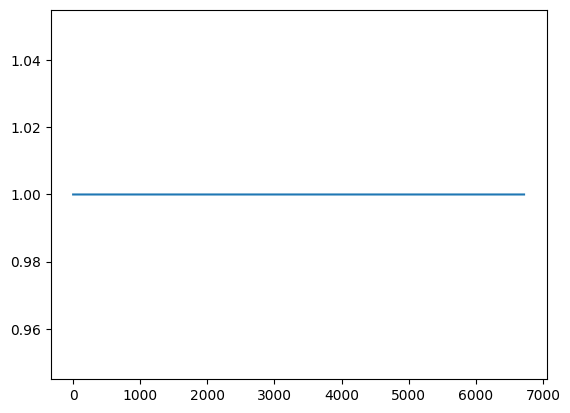

In [45]:
dl_errs_from_covs = [np.sqrt(cov[dl_idx, dl_idx]) for cov in results_updated['cov']]
plt.plot(results_updated['errors']['luminosity_distance']/dl_errs_from_covs)

### Check SNRs are matching with injected

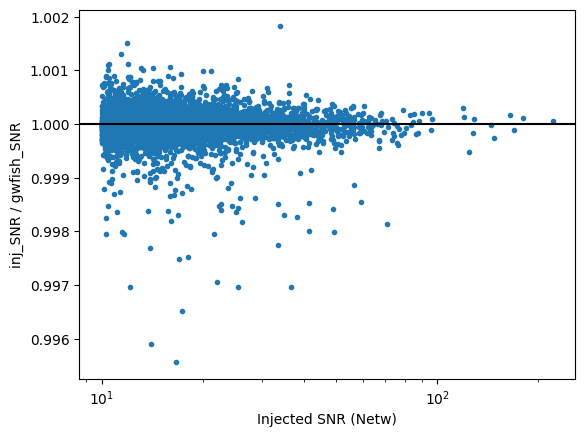

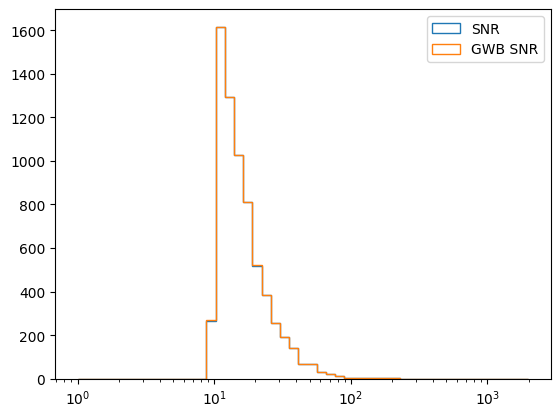

In [46]:
inj_snrs = results_updated['all_inj_params_original']['SNR_network']
gwfish_snrs = results_updated['netw_snrs']

plt.figure()
plt.plot(inj_snrs, inj_snrs/gwfish_snrs, '.')
plt.xlabel('Injected SNR (Netw)')
plt.ylabel('inj_SNR / gwfish_SNR')
plt.axhline(1, c='k')
plt.xscale('log')

plt.figure()
plt.hist(inj_snrs, bins=np.logspace(0,3.3,50), histtype=u'step', label='SNR');
plt.hist(gwfish_snrs, bins=np.logspace(0,3.3,50), histtype=u'step', label='GWB SNR');
plt.legend()
plt.xscale('log')

## Save to h5 file

### Write to file

In [47]:
print(results_updated.keys())
[type(results_updated[key]) for key in results_updated.keys()]

dict_keys(['netw_snrs', 'errors', 'sky_locs', 'all_inj_params_original', 'deriv_variables_in_order', 'inj_params', 'cov'])


[numpy.ndarray,
 pandas.core.frame.DataFrame,
 numpy.ndarray,
 pandas.core.frame.DataFrame,
 numpy.ndarray,
 pandas.core.frame.DataFrame,
 numpy.ndarray]

In [48]:
inj_data_file.split('/')[-1]

'LHI_SNR_4_pop_PLP_spin_prec_fref_10_z_MDhigh_zp_2.53_zmax_10_lmrd_22_365_days_corrected_td_SNR_data.h5'

In [49]:
file_str

'LHI_4_PLP_fref_10_z_MDhigh_zp_2.53_zmax_10_lmrd_22'

In [50]:
results_file = os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Errors',
                            f'{file_str}_no_spins_{len(results_updated["errors"])}_events_pop_from_XPHM_det10_opt.h5')
#results_file = os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Errors',
#                            f'LHI_Asharp_5_PLP_z_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_{len(results_updated["errors"])}_events_365_days_pop_from_XPHM_det10.h5')
results_file = results_file.replace('_fref_10', '').replace('LHI_', 'LHI_Asharp_')
results_file

'/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Errors/LHI_Asharp_4_PLP_z_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_6716_events_pop_from_XPHM_det10_opt.h5'

In [51]:
from utils import save_results_to_h5
save_results_to_h5(results_updated, results_file)

## Check that the file was saved properly

In [52]:
with h5py.File(results_file, 'r') as f:
    print(f.keys())
    print(f['errors'].keys())
    print(f['deriv_variables_in_order'][()])
    print(f['netw_snrs'][()])
    print(f['all_inj_params_original'].keys())

<KeysViewHDF5 ['all_inj_params_original', 'cov', 'deriv_variables_in_order', 'errors', 'inj_params', 'netw_snrs', 'sky_locs']>
<KeysViewHDF5 ['chirp_mass', 'dec', 'geocent_time', 'luminosity_distance', 'mass_ratio', 'phase', 'psi', 'ra', 'theta_jn']>
[b'chirp_mass' b'mass_ratio' b'luminosity_distance' b'theta_jn' b'phase'
 b'geocent_time' b'ra' b'dec' b'psi']
[12.11551808 11.77516311 13.51236126 ... 13.56447446 16.24866384
 20.21767735]
<KeysViewHDF5 ['PSD_H1', 'PSD_I1', 'PSD_L1', 'SNR_H1', 'SNR_I1', 'SNR_L1', 'SNR_mf_H1', 'SNR_mf_I1', 'SNR_mf_L1', 'SNR_mf_from_opt_H1', 'SNR_mf_from_opt_I1', 'SNR_mf_from_opt_L1', 'SNR_mf_from_opt_network', 'SNR_mf_network', 'SNR_network', 'approximant', 'chi_1_in_plane', 'chi_2_in_plane', 'chi_eff', 'chi_p', 'coa_phase', 'cos_spin1_polar', 'cos_spin2_polar', 'dec', 'delta_f', 'distance', 'eta', 'f_final', 'f_lower', 'f_ref', 'inclination', 'inv_q', 'log_distance', 'mass1', 'mass2', 'mchirp', 'mtotal', 'old_index', 'phi_12', 'phi_jl', 'polarization', 'q